In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import numpy as np


In [ ]:
file_path = '/content/drive/MyDrive/data_mining_project/2019-Oct.csv'
df = pd.read_csv(file_path)
df=df[df.category_code == 'computers.notebook']
df.describe(include='all')

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
count,1137623,1137623,1.137623e+06,1.137623e+06,1137623,1131269,1.137623e+06,1.137623e+06,1137623
unique,877612,3,NaN,NaN,1,17,NaN,NaN,245182
top,2019-10-04 04:23:33 UTC,view,NaN,NaN,computers.notebook,acer,NaN,NaN,2183f046-46f1-4ff6-96ef-f74986e7c8a1
freq,11,1106406,NaN,NaN,1137623,332100,NaN,NaN,578
mean,NaN,NaN,1.577923e+06,2.053358e+18,NaN,NaN,7.113579e+02,5.328464e+08,NaN
std,NaN,NaN,3.450528e+06,4.378678e+15,NaN,NaN,4.868676e+02,1.813606e+07,NaN
min,NaN,NaN,1.300742e+06,2.053014e+18,NaN,NaN,0.000000e+00,3.015733e+08,NaN
25%,NaN,NaN,1.306646e+06,2.053014e+18,NaN,NaN,3.603400e+02,5.156843e+08,NaN
50%,NaN,NaN,1.307073e+06,2.053014e+18,NaN,NaN,5.652900e+02,5.279154e+08,NaN
75%,NaN,NaN,1.307310e+06,2.053014e+18,NaN,NaN,8.749300e+02,5.501800e+08,NaN


In [ ]:
df.isna().sum()

event_time          0
event_type          0
product_id          0
category_id         0
category_code       0
brand            6354
price               0
user_id             0
user_session        0
dtype: int64

In [ ]:
item_by_brand = df.groupby("brand")["product_id"].count()\
    .to_frame().sort_values(by='product_id', ascending=False)
item_by_brand.head(10)

,product_id
brand,
acer,332100
lenovo,277025
hp,184966
asus,168564
apple,87292
dell,31695
xiaomi,23091
msi,15908
deepcool,4223


In [ ]:
def plot_distribution(df, title):
    # Convert 'event_time' to datetime
    df['event_time'] = pd.to_datetime(df['event_time'])

    # Weekly distribution with days of the week
    df['weekday'] = df['event_time'].dt.strftime('%A')
    weekly_counts = df.groupby(['weekday', 'event_type']).size().unstack(fill_value=0)

    # Order weekdays
    weekdays_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekly_counts = weekly_counts.reindex(weekdays_order, axis=0, fill_value=0)

    plt.figure(figsize=(14, 8))
    plt.subplot(2, 2, 1)
    weekly_counts.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
    plt.title(f'{title} - Weekly Counts of Events Over Time')
    plt.xlabel('Day of the Week')
    plt.ylabel('Event Count')
    plt.legend(title='Event Type', loc='upper right')

    # Hourly distribution
    df['hour'] = df['event_time'].dt.hour
    hourly_counts = df.groupby(['hour', 'event_type']).size().unstack(fill_value=0)

    plt.subplot(2, 2, 2)
    hourly_counts.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
    plt.title(f'{title} - Hourly Counts of Events Over Time')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Event Count')
    plt.legend(title='Event Type', loc='upper right')
    plt.xticks(rotation=0)

    plt.tight_layout()
    plt.show()


In [ ]:
df_original = df.sample(frac=0.05, random_state=42)

Original Dataset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 56881 entries, 22186834 to 25745302
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event_time     56881 non-null  object 
 1   event_type     56881 non-null  object 
 2   product_id     56881 non-null  int64  
 3   category_id    56881 non-null  int64  
 4   category_code  56881 non-null  object 
 5   brand          56584 non-null  object 
 6   price          56881 non-null  float64
 7   user_id        56881 non-null  int64  
 8   user_session   56881 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 4.3+ MB
None


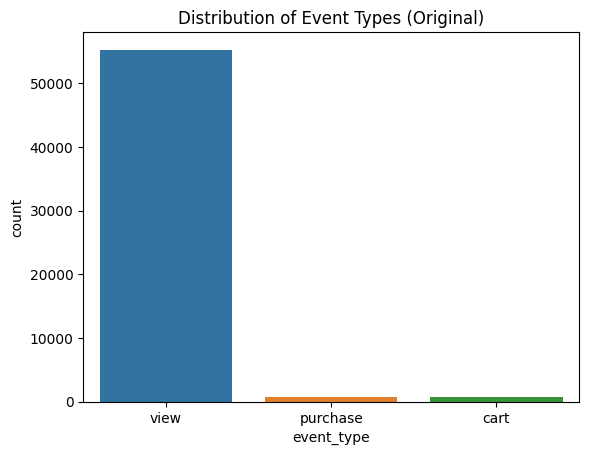

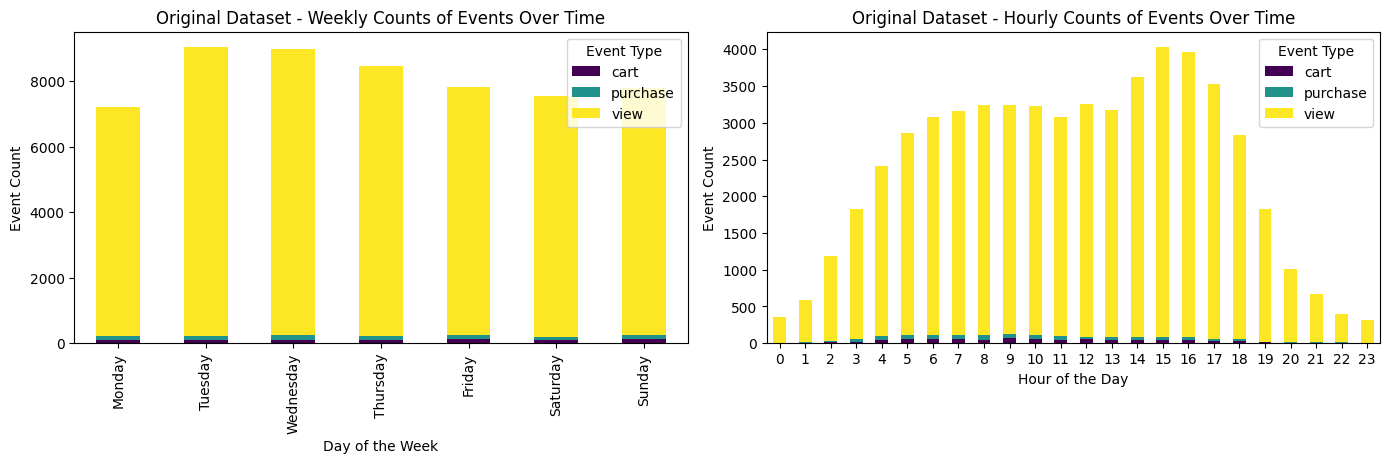

In [ ]:
# Display basic information about the original dataset
print("Original Dataset:")
print(df_original.info())

# Visualize the distribution of 'event_type' in the original dataset
sns.countplot(x='event_type', data=df_original)
plt.title('Distribution of Event Types (Original)')
plt.show()
plot_distribution(df_original, 'Original Dataset')

In [ ]:
# Balanced Dataset (Sampling 20,000 instances for each class)
df_balanced = df.groupby('event_type').apply(lambda x: x.sample(n=10000, random_state=42)).reset_index(drop=True)


Balanced Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event_time     30000 non-null  object 
 1   event_type     30000 non-null  object 
 2   product_id     30000 non-null  int64  
 3   category_id    30000 non-null  int64  
 4   category_code  30000 non-null  object 
 5   brand          29913 non-null  object 
 6   price          30000 non-null  float64
 7   user_id        30000 non-null  int64  
 8   user_session   30000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.1+ MB
None


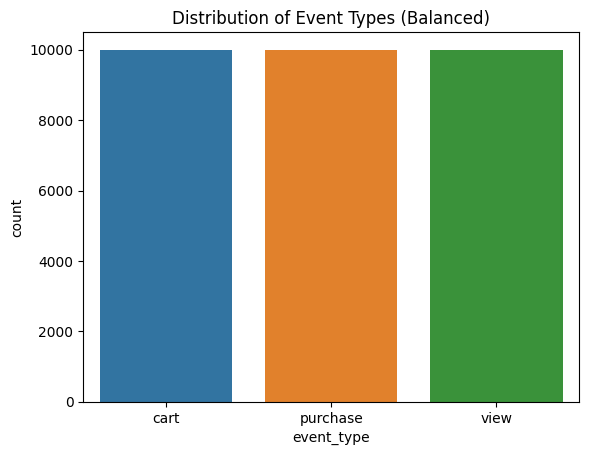

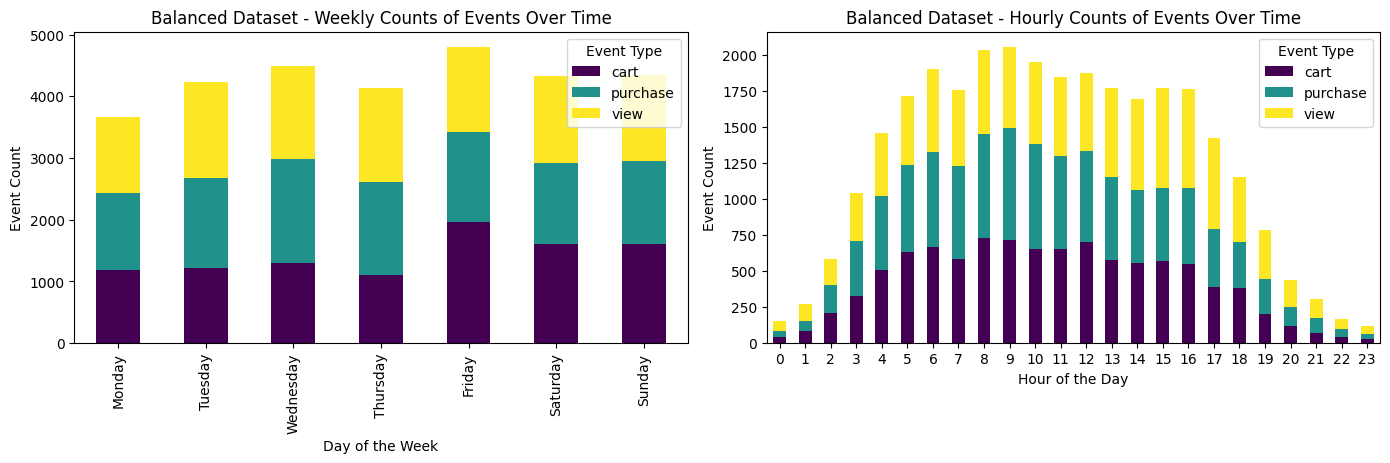

In [ ]:
# Display basic information about the balanced dataset
print("\nBalanced Dataset:")
print(df_balanced.info())

# Visualize the distribution of 'event_type' in the balanced dataset
sns.countplot(x='event_type', data=df_balanced)
plt.title('Distribution of Event Types (Balanced)')
plt.show()
plot_distribution(df_balanced, 'Balanced Dataset')

In [ ]:
def chi2_test(obs, exp, main_cat: int = 0, alpha=0.05):
    from scipy.stats import chi2_contingency

    # Create a contingency table
    contingency_table = pd.DataFrame({'Observed': obs, 'Expected': exp})

    # Perform the chi-square test
    chi2, p, _, _ = chi2_contingency(contingency_table)

    if p < alpha:
        print(f"Statistically significant under the level of significance = {alpha} ({p}). H0 rejected.")
    else:
        print(f"NOT statistically significant under the level of significance = {alpha} ({p}). H0 not rejected.")

    return chi2, p

In [ ]:
# Chi-square test for time tendency in a day
df_original['half_of_day'] = df_original['event_time'].dt.hour.apply(lambda x: 2 if x > 12 else 1)
df_original['event_retype'] = df_original['event_type'].apply(lambda x: 2 if x in ['cart', 'purchase'] else 1)

chi_crosstab_day = pd.crosstab(df_original['half_of_day'], df_original['event_retype'], margins=True)
print(chi_crosstab_day)

obs_day = chi_crosstab_day.iloc[0, :-1]
exp_day = chi_crosstab_day.iloc[1, :-1]
chi2_test(obs_day, exp_day)

event_retype      1     2    All
half_of_day                     
1             30458  1060  31518
2             24847   516  25363
All           55305  1576  56881
Statistically significant under the level of significance = 0.05 (1.0570883676527081e-21). H0 rejected.


(91.60717860958181, 1.0570883676527081e-21)

In [ ]:
# Chi-square test for time tendency in a week
df_original['weekday'] = df_original['event_time'].dt.day_name()
chi_crosstab_week = pd.crosstab(df_original['weekday'], df_original['event_retype'], margins=True)
print(chi_crosstab_week)

obs_week = chi_crosstab_week.iloc[:-1, 0]
exp_week = chi_crosstab_week.iloc[:-1, 1]
chi2_test(obs_week, exp_week)

event_retype      1     2    All
weekday                         
Friday         7570   263   7833
Monday         7011   212   7223
Saturday       7340   201   7541
Sunday         7545   240   7785
Thursday       8257   208   8465
Tuesday        8853   207   9060
Wednesday      8729   245   8974
All           55305  1576  56881
Statistically significant under the level of significance = 0.05 (0.0003487446972709579). H0 rejected.


(24.950440455296157, 0.0003487446972709579)

In [ ]:
# Common Preprocessing Steps for Both Datasets
for data in [df_original, df_balanced]:
    data['event_time'] = pd.to_datetime(data['event_time'])
    data['time_interval'] = pd.cut(data['event_time'].dt.hour,
                                   bins=[0, 6, 12, 18, 21, 24],
                                   labels=['Night', 'Morning', 'Afternoon', 'Evening', 'Midnight'])
    data['cost_category'] = pd.cut(data['price'],
                                   bins=[0, 500, 1000, float('inf')],
                                   labels=['Low Cost', 'Average Cost', 'High Cost'])
    data['week_day'] = data['event_time'].dt.day_name()

    label_encoder = LabelEncoder()
    data['time_interval'] = label_encoder.fit_transform(data['time_interval'])
    data['week_day'] = label_encoder.fit_transform(data['week_day'])
    data['cost_category'] = label_encoder.fit_transform(data['cost_category'])


Original Dataset - Decision Tree Classifier:
Model Accuracy: 97.28%


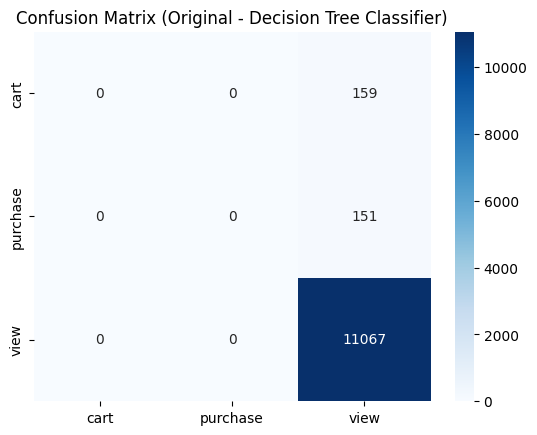

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report (Original - Decision Tree Classifier):
               precision    recall  f1-score   support

        cart       0.00      0.00      0.00       159
    purchase       0.00      0.00      0.00       151
        view       0.97      1.00      0.99     11067

    accuracy                           0.97     11377
   macro avg       0.32      0.33      0.33     11377
weighted avg       0.95      0.97      0.96     11377



'user_behavior_decision_tree_original.pdf'

In [ ]:
# Decision Tree Classifier for Original Dataset
X_original = df_original[['time_interval', 'week_day', 'cost_category']]
y_original = df_original['event_type']
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42
)

dt_model_original = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
dt_model_original.fit(X_train_original, y_train_original)

# Make predictions on the test set
y_pred_original_dt = dt_model_original.predict(X_test_original)

# Evaluate accuracy
accuracy_original_dt = accuracy_score(y_test_original, y_pred_original_dt)
print("\nOriginal Dataset - Decision Tree Classifier:")
print(f"Model Accuracy: {accuracy_original_dt:.2%}")

# Confusion Matrix
conf_matrix_original_dt = confusion_matrix(y_test_original, y_pred_original_dt)
sns.heatmap(conf_matrix_original_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['cart', 'purchase', 'view'], yticklabels=['cart', 'purchase', 'view'])
plt.title('Confusion Matrix (Original - Decision Tree Classifier)')
plt.show()

# Classification Report
class_report_original_dt = classification_report(y_test_original, y_pred_original_dt)
print("Classification Report (Original - Decision Tree Classifier):\n", class_report_original_dt)

# Decision Tree Visualization for the Original Dataset
dot_data_original_dt = export_graphviz(dt_model_original, out_file=None,
                                       feature_names=['time_interval', 'week_day', 'cost_category'],
                                       class_names=['cart', 'purchase', 'view'],
                                       filled=True, rounded=True, special_characters=True)

graph_original_dt = graphviz.Source(dot_data_original_dt)
graph_original_dt.render("user_behavior_decision_tree_original")
graph_original_dt.view("user_behavior_decision_tree_original")


Balanced Dataset - Decision Tree Classifier:
Model Accuracy: 40.52%


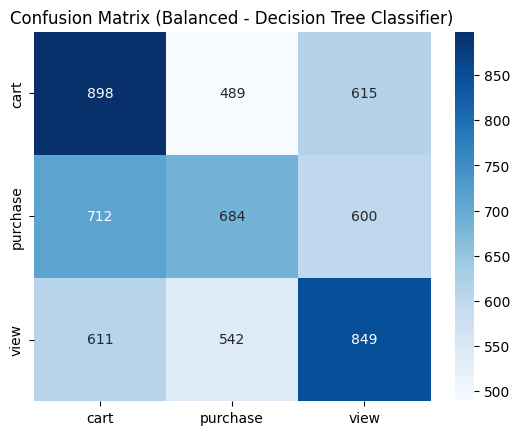

Classification Report (Balanced - Decision Tree Classifier):
               precision    recall  f1-score   support

        cart       0.40      0.45      0.43      2002
    purchase       0.40      0.34      0.37      1996
        view       0.41      0.42      0.42      2002

    accuracy                           0.41      6000
   macro avg       0.40      0.41      0.40      6000
weighted avg       0.40      0.41      0.40      6000



'user_behavior_decision_tree_balanced.pdf'

In [ ]:
# Decision Tree Classifier for Balanced Dataset
X_balanced = df_balanced[['time_interval', 'week_day', 'cost_category']]
y_balanced = df_balanced['event_type']
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42
)

dt_model_balanced = DecisionTreeClassifier(random_state=42)

# Fit the model to the training datan
dt_model_balanced.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test set
y_pred_balanced_dt = dt_model_balanced.predict(X_test_balanced)

# Evaluate accuracy
accuracy_balanced_dt = accuracy_score(y_test_balanced, y_pred_balanced_dt)
print("\nBalanced Dataset - Decision Tree Classifier:")
print(f"Model Accuracy: {accuracy_balanced_dt:.2%}")

# Confusion Matrix
conf_matrix_balanced_dt = confusion_matrix(y_test_balanced, y_pred_balanced_dt)
sns.heatmap(conf_matrix_balanced_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['cart', 'purchase', 'view'], yticklabels=['cart', 'purchase', 'view'])
plt.title('Confusion Matrix (Balanced - Decision Tree Classifier)')
plt.show()

# Classification Report
class_report_balanced_dt = classification_report(y_test_balanced, y_pred_balanced_dt)
print("Classification Report (Balanced - Decision Tree Classifier):\n", class_report_balanced_dt)

# Decision Tree Visualization for the Balanced Dataset
dot_data_balanced_dt = export_graphviz(dt_model_balanced, out_file=None,
                                       feature_names=['time_interval', 'week_day', 'cost_category'],
                                       class_names=['cart', 'purchase', 'view'],
                                       filled=True, rounded=True, special_characters=True)

graph_balanced_dt = graphviz.Source(dot_data_balanced_dt)
graph_balanced_dt.render("user_behavior_decision_tree_balanced")
graph_balanced_dt.view("user_behavior_decision_tree_balanced")

In [ ]:
# Model Training and Evaluation for Original Dataset
X_original = df_original[['time_interval', 'week_day', 'cost_category']]
y_original = df_original['event_type']
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42
)

rf_model_original = RandomForestClassifier(random_state=42)

param_grid_original = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_original = GridSearchCV(estimator=rf_model_original, param_grid=param_grid_original, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_original.fit(X_train_original, y_train_original)

best_rf_model_original = grid_search_original.best_estimator_
y_pred_original = best_rf_model_original.predict(X_test_original)

accuracy_original = accuracy_score(y_test_original, y_pred_original)
print("\nOriginal Dataset:")
print(f"Best Model Accuracy: {accuracy_original:.2%}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits

Original Dataset:
Best Model Accuracy: 97.28%


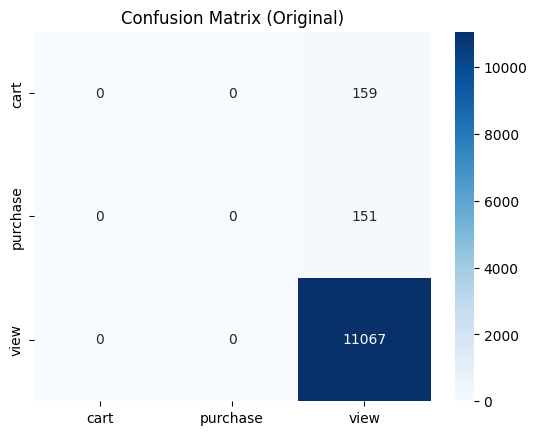

In [ ]:
# Confusion Matrix
conf_matrix_original = confusion_matrix(y_test_original, y_pred_original)
sns.heatmap(conf_matrix_original, annot=True, fmt='d', cmap='Blues', xticklabels=['cart', 'purchase', 'view'], yticklabels=['cart', 'purchase', 'view'])
plt.title('Confusion Matrix (Original)')
plt.show()

In [ ]:
# Classification Report
class_report_original = classification_report(y_test_original, y_pred_original)
print("Classification Report (Original):\n", class_report_original)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report (Original):
               precision    recall  f1-score   support

        cart       0.00      0.00      0.00       159
    purchase       0.00      0.00      0.00       151
        view       0.97      1.00      0.99     11067

    accuracy                           0.97     11377
   macro avg       0.32      0.33      0.33     11377
weighted avg       0.95      0.97      0.96     11377



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Decision Tree Visualization for the Original Dataset
dot_data_original = export_graphviz(best_rf_model_original.estimators_[0], out_file=None,
                                    feature_names=['time_interval', 'week_day', 'cost_category'],
                                    class_names=['cart', 'purchase', 'view'],
                                    filled=True, rounded=True, special_characters=True)

graph_original = graphviz.Source(dot_data_original)
graph_original.render("best_user_behavior_decision_tree_original")
graph_original.view("best_user_behavior_decision_tree_original")

'best_user_behavior_decision_tree_original.pdf'

In [ ]:
# Model Training and Evaluation for Balanced Dataset
X_balanced = df_balanced[['time_interval', 'week_day', 'cost_category']]
y_balanced = df_balanced['event_type']
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42
)

rf_model_balanced = RandomForestClassifier(random_state=42)

param_grid_balanced = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_balanced = GridSearchCV(estimator=rf_model_balanced, param_grid=param_grid_balanced, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_balanced.fit(X_train_balanced, y_train_balanced)

best_rf_model_balanced = grid_search_balanced.best_estimator_
y_pred_balanced = best_rf_model_balanced.predict(X_test_balanced)

accuracy_balanced = accuracy_score(y_test_balanced, y_pred_balanced)
print("\nBalanced Dataset:")
print(f"Best Model Accuracy: {accuracy_balanced:.2%}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits

Balanced Dataset:
Best Model Accuracy: 40.63%


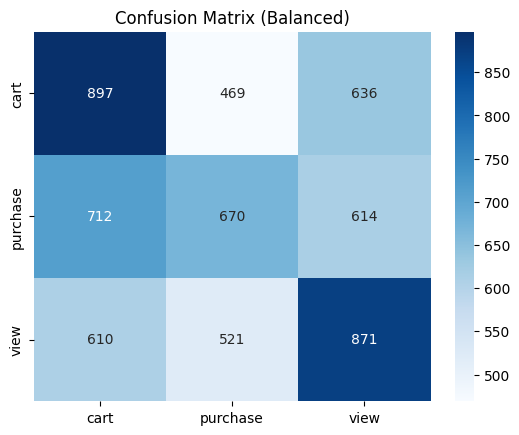

In [ ]:
# Confusion Matrix
conf_matrix_balanced = confusion_matrix(y_test_balanced, y_pred_balanced)
sns.heatmap(conf_matrix_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=['cart', 'purchase', 'view'], yticklabels=['cart', 'purchase', 'view'])
plt.title('Confusion Matrix (Balanced)')
plt.show()

In [ ]:
# Classification Report
class_report_balanced = classification_report(y_test_balanced, y_pred_balanced)
print("Classification Report (Balanced):\n", class_report_balanced)

Classification Report (Balanced):
               precision    recall  f1-score   support

        cart       0.40      0.45      0.43      2002
    purchase       0.40      0.34      0.37      1996
        view       0.41      0.44      0.42      2002

    accuracy                           0.41      6000
   macro avg       0.41      0.41      0.40      6000
weighted avg       0.41      0.41      0.40      6000



In [ ]:
# Decision Tree Visualization for the Balanced Dataset
dot_data_balanced = export_graphviz(best_rf_model_balanced.estimators_[0], out_file=None,
                                    feature_names=['time_interval', 'week_day', 'cost_category'],
                                    class_names=['cart', 'purchase', 'view'],
                                    filled=True, rounded=True, special_characters=True)

graph_balanced = graphviz.Source(dot_data_balanced)
graph_balanced.render("best_user_behavior_decision_tree_balanced")
graph_balanced.view("best_user_behavior_decision_tree_balanced")

'best_user_behavior_decision_tree_balanced.pdf'

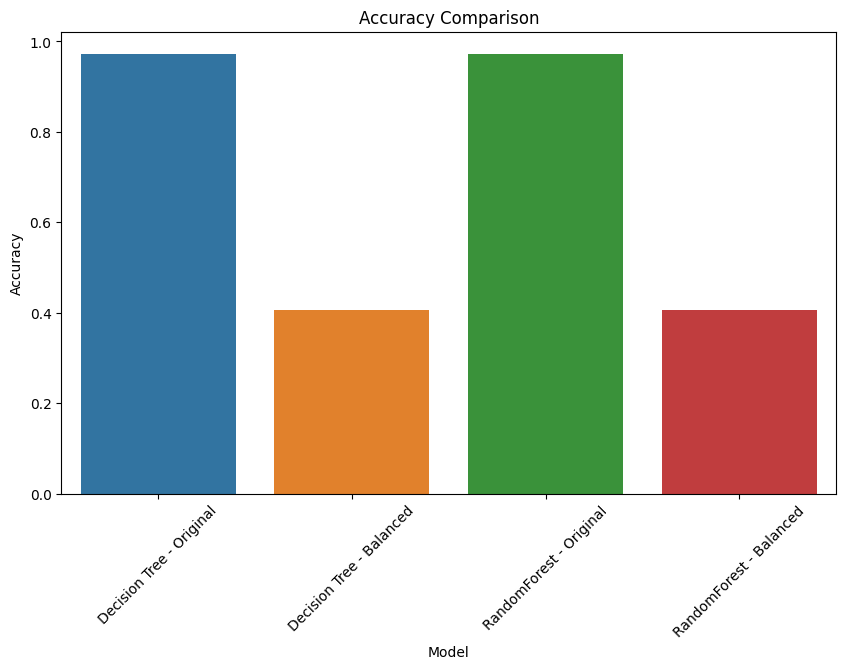

In [ ]:
# Calculate accuracy for each model and dataset
accuracy_original_dt = accuracy_score(y_test_original, y_pred_original_dt)
accuracy_balanced_dt = accuracy_score(y_test_balanced, y_pred_balanced_dt)
accuracy_original_rf = accuracy_score(y_test_original, y_pred_original)
accuracy_balanced_rf = accuracy_score(y_test_balanced, y_pred_balanced)

# Create DataFrame to store accuracies
accuracy_df = pd.DataFrame({
    'Model': ['Decision Tree - Original', 'Decision Tree - Balanced', 'RandomForest - Original', 'RandomForest - Balanced'],
    'Accuracy': [accuracy_original_dt, accuracy_balanced_dt, accuracy_original_rf, accuracy_balanced_rf]
})

# Plotting accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=accuracy_df)
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()
